In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Load data
X = pd.read_csv('data/fingerprints.csv', index_col = 0)
df = pd.read_csv('data/p2x4_final.csv', index_col = 0)
Y = df['pIC50']
# Feature Selection
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [3]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=6)

In [4]:
# Hyperparameter grid for XGBRegressor
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.8, 1],
    'colsample_bytree': [0.5, 0.8, 1]
}


In [5]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 4


In [6]:
# GridSearchCV for XGBRegressor
grid_search_xgb = GridSearchCV(estimator=XGBRegressor(random_state=6),
                               param_grid=param_grid_xgb, cv=5, n_jobs=N_CORES, verbose=2)
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=6, ...),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.5, 0.8, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 150],
                         'subsample': [0.5, 0.8, 1]},
             verbose=2)

In [7]:
# Selecting the best estimator from each GridSearchCV
best_model_xgb = grid_search_xgb.best_estimator_

# Step 1: Predict on Test Set

In [8]:
y_pred = best_model_xgb.predict(X_test)

# Step 2: Calculate Performance Metrics

Since this is a regression problem, you can use metrics such as Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, and R-squared

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculating the metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)
print('R2:', r2)


MSE: 0.2536944767148649
RMSE: 0.5036809274876952
MAE: 0.3421869720724016
R2: 0.8569670726686422


# Step 3: Analyze Residuals

Analyzing the residuals (difference between the predicted and actual values) can provide insights into the behavior of your model

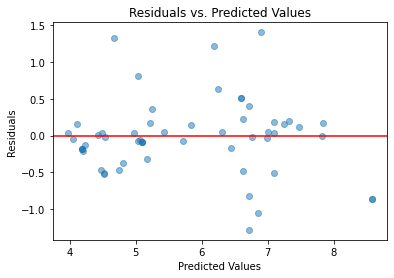

In [10]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Step 4: Compare with Baseline 

It can be helpful to compare your model's performance against a simple baseline model, such as predicting the mean of the target variable for all instances. This gives you a reference point for how much your model has learned.

In [11]:
# Baseline predictions (mean of target variable)
baseline_preds = np.full_like(y_test, np.mean(y_train))

# Baseline Mean Squared Error
baseline_mse = mean_squared_error(y_test, baseline_preds)

print(f"Baseline Mean Squared Error: {baseline_mse}")
print(f"Model Mean Squared Error: {mse}")

Baseline Mean Squared Error: 1.795130876257679
Model Mean Squared Error: 0.2536944767148649


In [12]:
print(f"Best XGBRegressor: {grid_search_xgb.best_params_}")

Best XGBRegressor: {'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 150, 'subsample': 1}


# Using the model with Maybridge compounds

In [13]:
maybridge_data = pd.read_csv("maybridge/Maybridge.csv")
maybridge_data

,SMILES,Code
0,Fc1ccc(C(c2ccc(F)cc2)N2CCNCC2)cc1,AC10018
1,CSc1nc(N)nc2nc[nH]c12,AC12157
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917
3,O=C(O)c1ccc(Br)o1,AC27191
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806
...,...,...
51768,CCO/C(C)=N/Oc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],S14814
51769,O=C1c2ccccc2C(=O)N1Oc1ccc([N+](=O)[O-])c([N+](...,S14839
51770,O=[N+]([O-])c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1,S14896
51771,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1/C=C/c1ccccc1,SPB05721


In [14]:
descriptors = pd.read_csv('maybridge/out.csv', index_col = 0)
descriptors.shape

(51773, 881)

In [15]:
descriptors = selection.transform(descriptors)
descriptors.shape

(51773, 155)

In [16]:
# Step 3: Make Predictions
predicted_pic50 = best_model_xgb.predict(descriptors)

In [17]:
# Step 4: Analyze Results
# Append predictions to the Maybridge data
maybridge_data["predicted_pic50"] = predicted_pic50

In [18]:
maybridge_data

,SMILES,Code,predicted_pic50
0,Fc1ccc(C(c2ccc(F)cc2)N2CCNCC2)cc1,AC10018,4.743007
1,CSc1nc(N)nc2nc[nH]c12,AC12157,5.083004
2,CN(C)Cc1c[nH]c2ccc(OCc3ccccc3)cc12,AC13917,5.174273
3,O=C(O)c1ccc(Br)o1,AC27191,5.042593
4,NC(Cc1c[nH]c2ccc(Br)cc12)C(=O)O,AC29806,5.570199
...,...,...,...
51768,CCO/C(C)=N/Oc1ccc([N+](=O)[O-])cc1[N+](=O)[O-],S14814,4.754600
51769,O=C1c2ccccc2C(=O)N1Oc1ccc([N+](=O)[O-])c([N+](...,S14839,5.147605
51770,O=[N+]([O-])c1ccc2nc(-c3ccccc3)c(-c3ccccc3)nc2c1,S14896,5.214167
51771,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OCC)C1/C=C/c1ccccc1,SPB05721,5.170449


In [19]:
# Identify potent inhibitors
threshold = 6 # Define a threshold for pic50 values 
potent_inhibitors = maybridge_data[maybridge_data["predicted_pic50"] >= threshold]

In [20]:
potent_inhibitors

,SMILES,Code,predicted_pic50
43,Nc1cccc2c1C(=O)NC2=O,AC36050,6.070008
65,O=C(O)c1ccccc1C(=O)Nc1ccc(-n2nccc2C(F)(F)F)cc1,AW00170,6.101089
66,O=C(Nc1ccc(-n2nccc2C(F)(F)F)cc1)c1ccc(Cl)cc1,AW00193,6.288528
105,O=C(Nc1ccc(Oc2ccc(OC(F)(F)F)cc2)cc1)c1ccc(Cl)c...,EN00233,6.028219
106,O=C(Nc1ccc(Oc2ccc(OC(F)(F)F)cc2)cc1)c1ccccc1O,EN00012,6.283979
...,...,...,...
51599,Cc1ccc(SC(C)C(=O)Nc2ccc(C(C)(C)C)cc2)cc1,S14657,6.395062
51600,CC(Sc1ccc(Cl)cc1)C(=O)Nc1ccc(C(C)(C)C)cc1,S14683,6.579539
51601,Cc1ccc(SCC(=O)Nc2ccc(C(C)(C)C)cc2)cc1,S14713,6.037635
51604,Cn1ccnc1SCC(=O)Nc1ccc(C(C)(C)C)cc1,S14548,6.003129


In [21]:
# Sort the potent_inhibitors DataFrame based on "predicted_pic50" in descending order
sorted_potent_inhibitors = potent_inhibitors.sort_values(by="predicted_pic50", ascending=False)
sorted_potent_inhibitors

,SMILES,Code,predicted_pic50
22204,NS(=O)(=O)c1ccc(NC(=O)CSc2nnc(-c3ccc(Cl)cc3)o2...,HTS04304,7.305128
41084,CC(C)(C)c1ccc2[nH]c(/C(=C\c3ccc(F)cc3)NC(=O)c3...,S02343,7.277198
1290,O=C(Nc1ccc2c(c1)COCO2)c1sc2ccccc2c1Cl,GK01509,7.260339
34483,COc1cc(OC)c(NC(=O)C(Sc2ccc(Cl)cc2)c2ccccc2)cc1Cl,HTS07898,7.135624
34487,COc1cc(OC)c(NC(=O)C(Sc2ccccc2N)c2ccccc2)cc1Cl,HTS07766,7.135624
...,...,...,...
14827,O=C(NNc1nc(-c2cc3ccccc3o2)cs1)c1ccc(Cl)cc1,CD08608,6.000489
1992,Cc1cc(Oc2ccc(C(F)(F)F)cc2NC(=O)c2c(F)cccc2F)cc...,AW01029,6.000487
24734,O=C(NC(=S)Nc1[nH]nc(C2CC2)c1/N=N/c1ccc(Cl)cc1)...,SPB06782,6.000397
24743,O=C(NC(=S)Nc1[nH]nc(C2CC2)c1/N=N/c1ccccc1Cl)c1...,SPB06771,6.000397


In [22]:
sorted_potent_inhibitors.predicted_pic50.describe()

count    2062.000000
mean        6.261891
std         0.218859
min         6.000176
25%         6.084010
50%         6.203976
75%         6.403283
max         7.305128
Name: predicted_pic50, dtype: float64

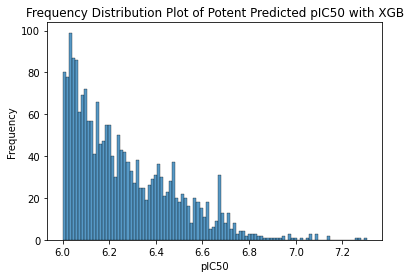

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data=potent_inhibitors, x='predicted_pic50', kde=False, bins=100)

# Set the title and labels for the plot
plt.title('Frequency Distribution Plot of Potent Predicted pIC50 with XGB')
plt.xlabel('pIC50')
plt.ylabel('Frequency')


plt.savefig('figures/potent_predicted_xgb.png')
# Show the plot
plt.show()

In [24]:
# Save the potent inhibitors to a CSV file
potent_inhibitors.to_csv("maybridge/xgb_potent_p2x4_inhibitors.csv", index=False)

In [25]:
# 1. Load the common potent inhibitors
common_df = pd.read_csv("maybridge/common_potent_inhibitors.csv")
common_df

,smiles
0,O=C(Nc1ccccc1Cl)c1ccc(-c2ccccn2)s1
1,O=C(Nc1ccccc1Sc1nc2ccc(Cl)cc2s1)c1ccc(F)cc1
2,COC(=O)c1cccc(NC(=O)c2ccc(Cl)cc2)c1
3,N#Cc1ccc(-c2c(NC(=O)NS(=O)(=O)c3ccccc3Cl)oc(-c...
4,Cc1onc(-c2ccccc2)c1C(=O)Nc1ccc(C(F)(F)F)cc1Cl
...,...
383,Cc1cc(NS(=O)(=O)c2ccc(NC(=O)c3ccccc3Cl)cc2)no1
384,O=C(Nc1cccc(-c2nc3ccccc3[nH]2)c1)c1ccc(F)cc1
385,O=C(Nc1ccc(NC(=S)Nc2ccc(Cl)cc2)cc1)c1ccccc1O
386,Cc1c(CC(=O)Nc2ccc(Cl)cc2)sc2ccc(Cl)cc12


In [26]:
filtered_potent_inhibitors = potent_inhibitors[potent_inhibitors["SMILES"].isin(common_df["smiles"])]
filtered_potent_inhibitors

,SMILES,Code,predicted_pic50
66,O=C(Nc1ccc(-n2nccc2C(F)(F)F)cc1)c1ccc(Cl)cc1,AW00193,6.288528
110,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,EN00095,6.323017
250,CC(=O)Nc1ccc(S(=O)(=O)Nc2ccc(Oc3ccc(OC(F)(F)F)...,AW00256,6.323017
650,CC(=O)Nc1cccc(OCCCNS(=O)(=O)c2ccc(N3C(=O)CC4(C...,AW00490,6.311470
758,O=C(NCCNS(=O)(=O)c1ccc(Cl)cc1)C1=Cc2cc(Cl)ccc2OC1,GK00081,6.608722
...,...,...,...
49720,Cc1onc(-c2ccc(Cl)cc2)c1-c1ccnc(SCC(=O)Nc2ccc(C...,S10227,6.110887
49780,Cc1cc(-c2nc(C)c(-c3nnc(SCC(=O)Nc4ccc(C(C)C)cc4...,S15050,6.418315
50705,CCOC(=O)c1cc2c(NC(=O)c3ccc(Cl)cc3)c(C(=O)OCC)s...,RJF02129,6.518190
51287,O=C(Cc1ccccc1)Nc1ccc(Cl)cc1,S13395,6.450453


In [27]:
filtered_potent_inhibitors.predicted_pic50.describe()

count    394.000000
mean       6.407001
std        0.227908
min        6.003438
25%        6.235743
50%        6.403748
75%        6.570165
max        7.305128
Name: predicted_pic50, dtype: float64

In [29]:
# 3. Sort the filtered data based on pic50 values in descending order (assuming higher is more potent)
sorted_common = filtered_potent_inhibitors.sort_values(by="predicted_pic50", ascending=False)
sorted_common

,SMILES,Code,predicted_pic50
22204,NS(=O)(=O)c1ccc(NC(=O)CSc2nnc(-c3ccc(Cl)cc3)o2...,HTS04304,7.305128
41084,CC(C)(C)c1ccc2[nH]c(/C(=C\c3ccc(F)cc3)NC(=O)c3...,S02343,7.277198
43120,Cc1c(C(=O)Nc2cc(-c3ccc(Cl)cc3)n[nH]2)cnn1-c1cc...,NRB04791,7.085925
8227,O=C(O)c1cccc([N+](=O)[O-])c1C(=O)Nc1ccc(Cl)c(C...,CD05497,7.046091
1247,Cc1cc(OC(=O)c2sc3ccccc3c2Cl)n(-c2ccc(NC(=O)c3s...,AW00837,7.025437
...,...,...,...
25076,CSc1sc(C(=O)NC(C)(C)C)c(-c2ccc(Cl)cc2)c1C#N,DSHS00486,6.016872
49667,CC(C)c1ccc(NC(=O)CSc2nccc(-c3cc(-c4ccc(Cl)cc4)...,RJC04003,6.016033
49671,CC(C)c1ccc(NC(=O)CSc2nccc(-c3cc(-c4ccccc4Cl)no...,RJC04047,6.016033
49659,CC(C)c1ccc(NC(=O)CSc2nccc(-c3cc(-c4ccc(Cl)cc4C...,RJC04027,6.016033


In [33]:
# Save the potent inhibitors to a CSV file
sorted_common.to_csv("maybridge/xgb_sorted_common.csv", index=False)

In [30]:
best_model_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=6, ...)

In [31]:
top20 = sorted_common.sort_values(by="predicted_pic50", ascending=False).head(20)
top20

,SMILES,Code,predicted_pic50
22204,NS(=O)(=O)c1ccc(NC(=O)CSc2nnc(-c3ccc(Cl)cc3)o2...,HTS04304,7.305128
41084,CC(C)(C)c1ccc2[nH]c(/C(=C\c3ccc(F)cc3)NC(=O)c3...,S02343,7.277198
43120,Cc1c(C(=O)Nc2cc(-c3ccc(Cl)cc3)n[nH]2)cnn1-c1cc...,NRB04791,7.085925
8227,O=C(O)c1cccc([N+](=O)[O-])c1C(=O)Nc1ccc(Cl)c(C...,CD05497,7.046091
1247,Cc1cc(OC(=O)c2sc3ccccc3c2Cl)n(-c2ccc(NC(=O)c3s...,AW00837,7.025437
2912,CC(=O)Nc1cc2cc(NS(=O)(=O)c3ccc(Cl)c(Cl)c3)ccc2...,SCR00073,6.978092
2231,CC(=O)Nc1cc2cc(NS(=O)(=O)c3ccc(Cl)cc3)ccc2oc1=O,AW01119,6.978092
1172,O=C(CCc1ccc(O)cc1)NNC(=S)Nc1ccc(Cl)c(Cl)c1,AW00768,6.975824
40778,O=C(O)/C=C/C(=O)Nc1ccc(Cl)c(C(=O)O)c1,HTS12679,6.932151
41986,O=C(Cc1ccccc1Cl)NC1(O)C(=O)c2ccccc2C1=O,RH01361,6.879158


In [32]:
top20.to_csv("maybridge/xgb_top20.csv", index=False)